In [305]:
seq_length = 5 # 你可以调整这个值
split_ratio=0.7
input_size=1
hidden_size=3
output_size=1
num_epochs = 100

In [306]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import Dataset, DataLoader
import tqdm

In [307]:
df=pd.read_csv("angles_by_hour.csv")
df.head()

,date,y
0,2024-03-12 00:00:00,0.07148
1,2024-03-12 01:00:00,0.15133
2,2024-03-12 02:00:00,0.23718
3,2024-03-12 03:00:00,0.31093
4,2024-03-12 04:00:00,0.39295


In [308]:
# 确保 'date' 是 datetime 类型，并排序
df['date'] = pd.to_datetime(df['date'])
df = df.sort_values('date')

# 仅保留 'y' 作为输入
y_data = df['y'].values

# 定义时间窗口大小


In [309]:

# 自定义 Dataset
class TimeSeriesDataset(Dataset):
    def __init__(self, data, seq_length):
        self.data = data
        self.seq_length = seq_length

    def __len__(self):
        return len(self.data) - self.seq_length

    def __getitem__(self, idx):
        x = self.data[idx:idx + self.seq_length]
        y = self.data[idx + self.seq_length]
        return torch.tensor(x, dtype=torch.float32), torch.tensor(y, dtype=torch.float32)

In [310]:
# %% 数据集分割
train_size = int(len(y_data) * split_ratio)  
train_data, test_data = y_data[:train_size], y_data[train_size:]

# 创建训练和测试集 Dataset 和 DataLoader
train_dataset = TimeSeriesDataset(train_data, seq_length)
test_dataset = TimeSeriesDataset(test_data, seq_length)

train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [311]:
class SimpleRNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(SimpleRNN, self).__init__()
        self.rnn=nn.RNN(input_size, hidden_size, batch_first=True)
        self.linear = nn.Linear(hidden_size, output_size)
        
    def forward(self,x_batch):
        h0=torch.zeros(1,x_batch.size(0),hidden_size).to(x_batch.device)
        out,_=self.rnn(x_batch,h0)
        out=self.linear(out[:,-1,:])
        return out




In [312]:
# 实例化模型
model = SimpleRNN(input_size, hidden_size, output_size)

# %% 设置损失函数和优化器
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


# %% 训练模型
for epoch in tqdm.tqdm(range(num_epochs)):
    model.train()

    for x_batch, y_batch in train_dataloader:
        x_batch = x_batch.unsqueeze(2)  # 添加一个维度，使其变为 (batch_size, seq_length, input_size)

        optimizer.zero_grad()  # 清除之前的梯度
        outputs = model(x_batch)  # 正向传播
        loss = criterion(outputs, y_batch.unsqueeze(1))  # 计算损失，y_batch 需要调整为 (batch_size, 1)

        loss.backward()  # 反向传播
        optimizer.step()  # 更新参数

 

100%|██████████| 100/100 [00:04<00:00, 23.09it/s]


In [313]:
# %% 保存模型
torch.save(model.state_dict(), "simple_rnn_model.pth")
print("Model saved to simple_rnn_model.pth")

Model saved to simple_rnn_model.pth


In [314]:

#加载模型
model = SimpleRNN(input_size=1, hidden_size=hidden_size, output_size=1)
model.load_state_dict(torch.load("simple_rnn_model.pth"))
model.eval()  # 设置为评估模式

SimpleRNN(
  (rnn): RNN(1, 3, batch_first=True)
  (linear): Linear(in_features=3, out_features=1, bias=True)
)

In [315]:

# %% 加载模型
model = SimpleRNN(input_size=1, hidden_size=hidden_size, output_size=1)
model.load_state_dict(torch.load("simple_rnn_model.pth"))
model.eval()  # 设置为评估模式

SimpleRNN(
  (rnn): RNN(1, 3, batch_first=True)
  (linear): Linear(in_features=3, out_features=1, bias=True)
)

In [316]:

# %% 进行预测并可视化
predictions = []
true_values = []

with torch.no_grad():  # 禁用梯度计算
    for x_batch, y_batch in test_dataloader:
        x_batch = x_batch.unsqueeze(2)  # 重新调整输入形状
        outputs = model(x_batch)
        predictions.append(outputs.numpy())
        true_values.append(y_batch.numpy())

# 将预测值和真实值转换为 numpy 数组
predictions = np.concatenate(predictions, axis=0)
true_values = np.concatenate(true_values, axis=0)

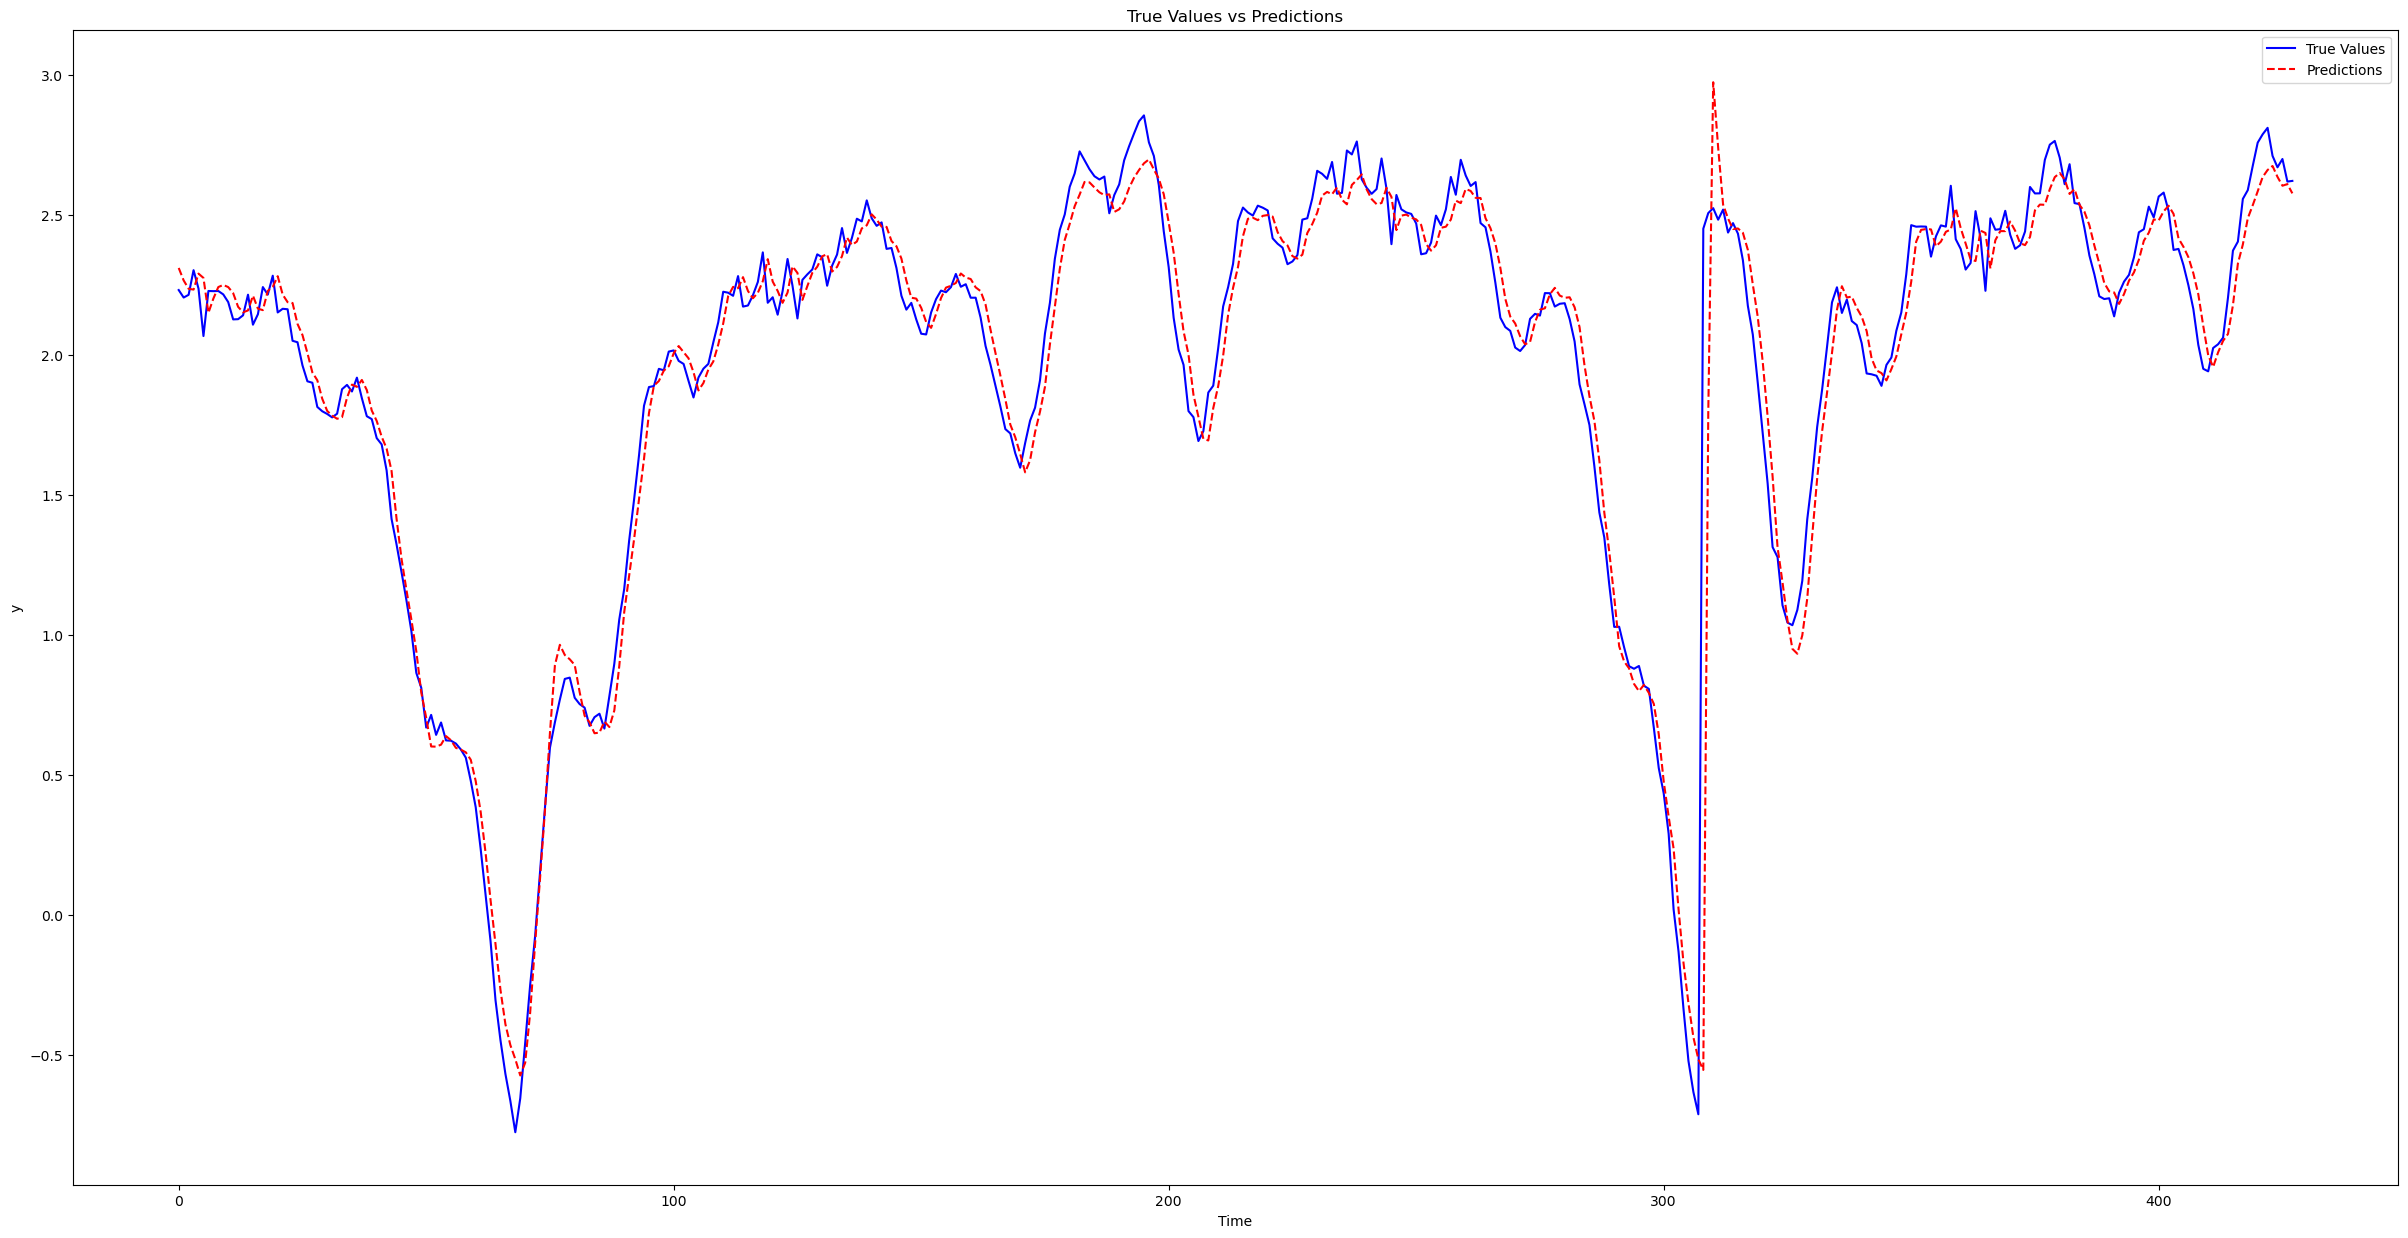

In [317]:

# 可视化预测值与真实值
plt.figure(figsize=(30, 15))
plt.plot(true_values, label="True Values", color='blue')
plt.plot(predictions, label="Predictions", color='red', linestyle='dashed')
plt.xlabel('Time')
plt.ylabel('y')
plt.title('True Values vs Predictions')
plt.legend()
plt.show()